In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset path
dataset_path = '/content/drive/MyDrive/Datasets'

Mounted at /content/drive


In [ ]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ImageDataGenerator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

# Training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation data
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 656 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 359s 17s/step - accuracy: 0.8050 - loss: 0.4735 - val_accuracy: 0.8841 - val_loss: 0.2745
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9021 - loss: 0.2497 - val_accuracy: 0.9573 - val_loss: 0.1773
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9426 - loss: 0.1489 - val_accuracy: 0.9695 - val_loss: 0.1222
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9601 - loss: 0.1026 - val_accuracy: 0.9878 - val_loss: 0.1201
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.9689 - loss: 0.0957 - val_accuracy: 0.9939 - val_loss: 0.0960
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9751 - loss: 0.0824 - val_accuracy: 0.9695 - val_loss: 0.1020
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9865 - loss: 0.0539 - val_accuracy: 0.9939 - val_loss: 0.0867
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9889 - loss: 0.0472 - val_accuracy: 0.9939 - val_los

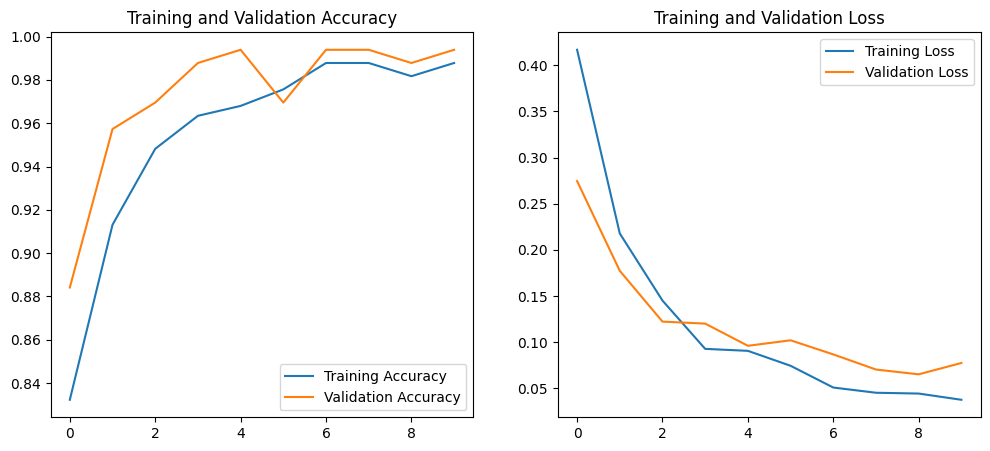

In [ ]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_training(history)


6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


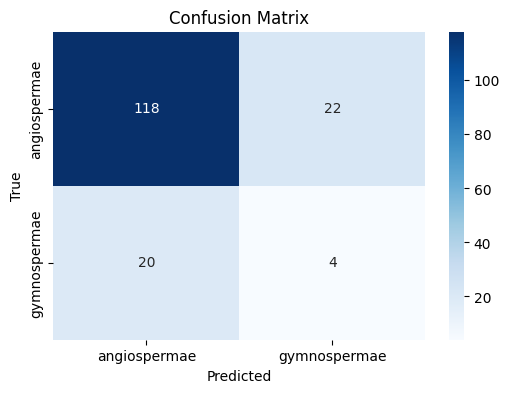

Classification Report:

              precision    recall  f1-score   support

angiospermae       0.86      0.84      0.85       140
gymnospermae       0.15      0.17      0.16        24

    accuracy                           0.74       164
   macro avg       0.50      0.50      0.50       164
weighted avg       0.75      0.74      0.75       164



In [ ]:
# Confusion Matrix dan Classification Report
val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
model.save('klasifikasi_tanaman_tf_model.h5')

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflowjs as tfjs
import os

# Simpan model ke format SavedModel
model.export('model_angio_gymno')


# Export ke format TensorFlow.js
!mkdir tfjs_model
tfjs.converters.convert_tf_saved_model('model_angio_gymno', 'tfjs_model')


Saved artifact at 'model_angio_gymno'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137876243409872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243410448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243413520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243413136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243410064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243413712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243412752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243409104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243413904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137876243408912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378762434142